In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [8]:
Sum=0
call=0
def Sum_Rec(n,S=0,call=0,itr=(0,1)):
    if n==0:
        return S,call
    else:
        S=S+n
        return Sum_Rec(n-1,S,call+1)
print(Sum_Rec(50))

(1275, 50)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Malus's Law: I = I0 * cos^2(theta)
def malus_law(theta, I0):
    return I0 * np.cos(np.radians(theta))**2

# Input the data: corrected angles in degrees and corresponding voltage values
angles = np.array([0, 4, 14, 24, 44, 64, 74, 84, 94, 104, 
                   124, 134, 144, 154, 164, 174, 184, 194, 204, 224, 
                   244, 264, 274, 284, 299, 304, 324, 344, 354, 360])
voltages = np.array([0.81, 0.98, 0.149, 0.202, 0.279, 0.289, 
                     0.274, 0.239, 0.186, 0.141, 0.048, 0.016, 
                     0.001, 0.004, 0.025, 0.063, 0.108, 0.16, 
                     0.209, 0.28, 0.287, 0.234, 0.189, 0.146, 
                     0.086, 0.051, 0.001, 0.024, 0.056, 0.075])

# Square the voltage values to get intensity (since I ∝ V^2)
intensities = voltages**2

# Initial guess for I0 (maximum intensity)
I0_guess = max(intensities)

# Perform curve fitting using least squares method
popt, pcov = curve_fit(malus_law, angles, intensities, p0=[I0_guess])

# Extract the fitted parameter I0
I0_fitted = popt[0]
print(f"Fitted I0 (Intensity at maximum): {I0_fitted}")

# Create a table with angle, cos^2(theta), voltage, and intensity
cos2_theta = np.cos(np.radians(angles))**2
data = {
    'Angle (degrees)': angles,
    'cos^2(theta)': cos2_theta,
    'Voltage (V)': voltages,
    'Intensity (V^2)': intensities
}

# Convert to a DataFrame for easy display
df = pd.DataFrame(data)

# Display the table
print(df)


Fitted I0 (Intensity at maximum): 0.1399190121191155
    Angle (degrees)  cos^2(theta)  Voltage (V)  Intensity (V^2)
0                 0      1.000000        0.810         0.656100
1                 4      0.995134        0.980         0.960400
2                14      0.941474        0.149         0.022201
3                24      0.834565        0.202         0.040804
4                44      0.517450        0.279         0.077841
5                64      0.192169        0.289         0.083521
6                74      0.075976        0.274         0.075076
7                84      0.010926        0.239         0.057121
8                94      0.004866        0.186         0.034596
9               104      0.058526        0.141         0.019881
10              124      0.312697        0.048         0.002304
11              134      0.482550        0.016         0.000256
12              144      0.654508        0.001         0.000001
13              154      0.807831        0.004     

In [155]:
import numpy as np
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorSampler

from qiskit_ibm_runtime import QiskitRuntimeService

In [157]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service=QiskitRuntimeService()
backend=service.least_busy(operational=True)

In [158]:
pm=generate_preset_pass_manager(optimization_level=3,backend=backend)


In [159]:
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

In [160]:
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit.circuit.library import LinearAmplitudeFunction

In [167]:
from qiskit import QuantumCircuit

In [168]:
num_qubits=3

In [169]:
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european, range(num_qubits))

# draw the circuit
european_call.draw()

NameError: name 'european' is not defined

In [165]:
def classical_monte_carlo(num=10000):
    np.random.seed(42)
    sample_price=np.random.lognormal(mean=0.12,sigma=0.24,size=num)
    payoffs=np.maximum(sample_price-1.05,0)
    expected=np.mean(payoffs)
    return expected
def quantum_mc(low,high,model):
    num_qubits=3 
    european=LinearAmplitudeFunction(
        num_state_qubits=num_qubits,
        rescaling_factor=0.25,
        domain=(low,high),
        breakpoints=[low,1.05],
        uncertainty_model=model,
    )
    european_call = QuantumCircuit(num_qubits)
    european_call.append(uncertainty_model, range(num_uncertainty_qubits))
    european_call.append(european, range(num_qubits))

    problem=EstimationProblem(
        state_preparation=european_call,
        objective_qubits=[3],
        post_processing=european.post_processing,
    )
    epsilon=0.01
    alpha=0.05
    iae=IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=StatevectorSampler(run_options={"shots": 100, "seed": 75}),
    )
    result=iae.estimate(problem)
    return result 
res=quantum_mc(low,high,uncertainty_model)
print(res)

TypeError: LinearAmplitudeFunction.__init__() got an unexpected keyword argument 'uncertainty_model'

Estimated payoff value: 0.3654617769228266


C:\Users\Rajat\AppData\Local\Temp\ipykernel_17912\1537690463.py:38: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


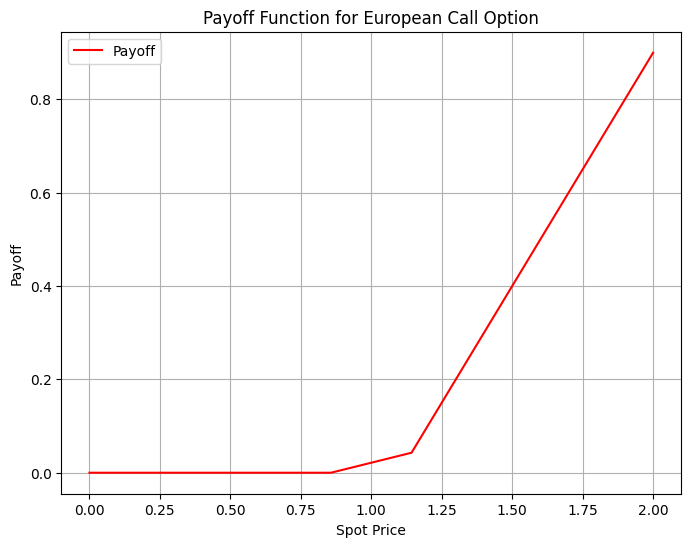

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit.primitives import Sampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

# 1. Set up the uncertainty model (LogNormal distribution)
num_uncertainty_qubits = 3
mu = 0.12  # Expected return
sigma = 0.24  # Volatility
low = 0
high = 2.0  # Asset price range

# Define the LogNormalDistribution to simulate asset prices
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

# 2. Set up the European Call Pricing
strike_price = 1.1
rescaling_factor = 0.25
european_call = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=rescaling_factor,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

# 3. Define the estimation problem
problem = european_call.to_estimation_problem()

# 4. Set up and run the Iterative Amplitude Estimation (IAE)
epsilon = 0.01  # target accuracy
alpha = 0.05  # confidence level

# Sampler to simulate circuits
sampler = Sampler()

# Iterative Amplitude Estimation
iae = IterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, sampler=sampler)
result = iae.estimate(problem)

# 5. Print the estimated value
print(f"Estimated payoff value: {result.estimation}")

# 6. Visualize the result
plt.figure(figsize=(8, 6))
plt.plot(uncertainty_model.values, np.maximum(0, uncertainty_model.values - strike_price), 'r-', label="Payoff")
plt.title("Payoff Function for European Call Option")
plt.xlabel("Spot Price")
plt.ylabel("Payoff")
plt.grid(True)
plt.legend()
plt.show()


In [219]:
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit import QuantumCircuit

def generate_ae(num, uncertainty_model,low=0, high=5.0):
    num_uncertainty_qubits = num
    strike_price = 3
    
    # Set the approximation scaling for the payoff function
    c_approx = 0.25

    # Setup piecewise linear objective function
    breakpoints = [low, strike_price]
    slopes = [0, 1]
    offsets = [0, 0]
    f_min = 0
    f_max = high - strike_price
    
    # Define the linear amplitude function for the European call option
    european_call_objective = LinearAmplitudeFunction(
        num_uncertainty_qubits,
        slopes,
        offsets,
        domain=(low, high),
        image=(f_min, f_max),
        breakpoints=breakpoints,
        rescaling_factor=c_approx,
    )
    
    # Get the number of qubits required for the objective function
    num_qubits = european_call_objective.num_qubits
    
    # Create the quantum circuit
    european_call = QuantumCircuit(num_qubits)
    
    # Add the uncertainty model to the circuit
    european_call.append(uncertainty_model, range(num_uncertainty_qubits))
    
    # Add the amplitude function (European call objective) to the circuit
    european_call.append(european_call_objective, range(num_qubits))

    return european_call


In [220]:
num_qubits = 4  # Number of qubits for state representation
S_T = 7        # Asset price
K = 3          # Strike price
r = 0.1        # Discount rate
T = 1        

In [221]:
qsp_circuit = create_qsp_circuit(num_qubits, S_T, K, r, T)
qc_qsp_transpiled = pm.run(qsp_circuit)
qsp_depths.append(qc_qsp_transpiled.depth())

In [226]:
qsp_depth=[]
for i in range (2,8):
    qsp_circuit = create_qsp_circuit(i, S_T, K, r, T)
    qc_qsp_transpiled = pm.run(qsp_circuit)
    qsp_depth.append(qc_qsp_transpiled.depth())

In [227]:
print(qsp_depth)

[5, 6, 6, 6, 6, 6]


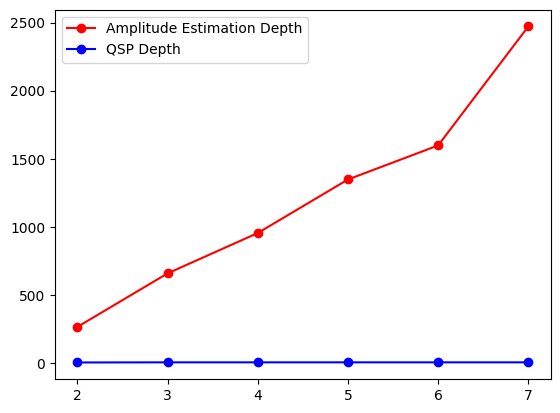

In [228]:
qubit=[]
depth=[]
for i in range (2,8):
    num_uncertainty_qubits=i
    num_uncertainty_qubits=num_uncertainty_qubits
    uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
    )
    circ=generate_ae(num=num_uncertainty_qubits,uncertainty_model=uncertainty_model)
    isa_circ=pm.run(circ)
    qubit.append(i)
    depth.append(isa_circ.depth())
plt.plot(qubit,depth,"ro-",label="Amplitude Estimation Depth")
plt.plot(qubit,qsp_depth,"bo-",label="QSP Depth")
plt.legend()
plt.show()

In [190]:
num_uncertainty_qubits=8

In [191]:
num_uncertainty_qubits=num_uncertainty_qubits
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [192]:

circ=generate_ae(num=num_uncertainty_qubits,uncertainty_model=uncertainty_model)
circ.draw()

┌───────┐┌─────┐
 q_0: ┤0      ├┤0    ├
      │       ││     │
 q_1: ┤1      ├┤1    ├
      │       ││     │
 q_2: ┤2      ├┤2    ├
      │       ││     │
 q_3: ┤3      ├┤3    ├
      │  P(X) ││     │
 q_4: ┤4      ├┤4    ├
      │       ││     │
 q_5: ┤5      ├┤5    ├
      │       ││     │
 q_6: ┤6      ├┤6    ├
      │       ││     │
 q_7: ┤7      ├┤7    ├
      └───────┘│     │
 q_8: ─────────┤8  F ├
               │     │
 q_9: ─────────┤9    ├
               │     │
q_10: ─────────┤10   ├
               │     │
q_11: ─────────┤11   ├
               │     │
q_12: ─────────┤12   ├
               │     │
q_13: ─────────┤13   ├
               │     │
q_14: ─────────┤14   ├
               │     │
q_15: ─────────┤15   ├
               │     │
q_16: ─────────┤16   ├
               └─────┘

In [ ]:
 if

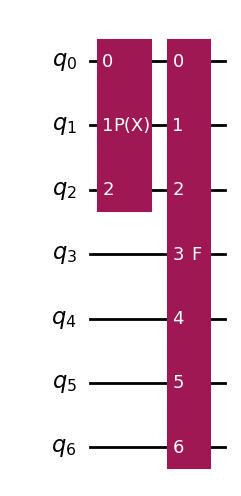

In [180]:
strike_price = 1.05
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.decompose().draw(fold=-1,output="mpl")

In [174]:
from qiskit import transpile

In [154]:
pm=generate_preset_pass_manager(backend=backend,optimization_level=3) 


In [ ]:
isa_european=pm.run(european_call)
isa_european.draw(output="mpl",fold=20,idle_wires=False)

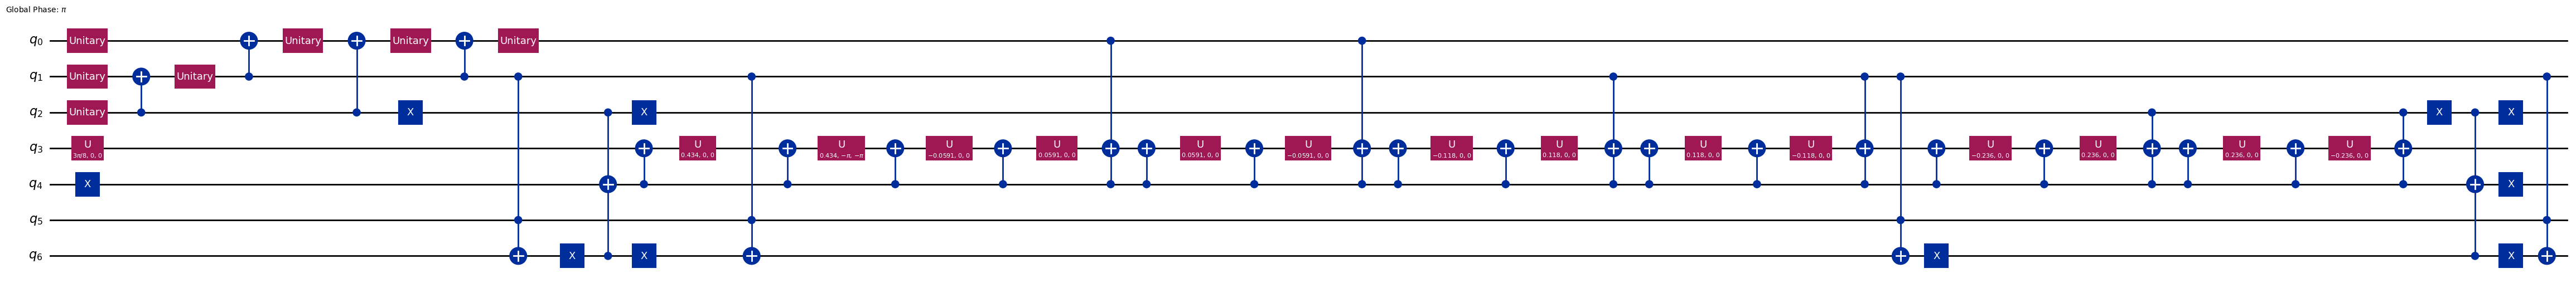

In [175]:
backend_sim=AerSimulator()
sim_european=transpile(european_call,backend_sim)
sim_european.draw(output="mpl",fold=-1)

In [177]:
print(f"Circuit Depth for Simulator Transpilation: {sim_european.depth()}")
print(f"Circuit Depth for ISA Circuit of {backend.name}: {isa_european.depth()}")

Circuit Depth for Simulator Transpilation: 49
Circuit Depth for ISA Circuit of ibm_brisbane: 592


In [28]:

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ResourceEstimation

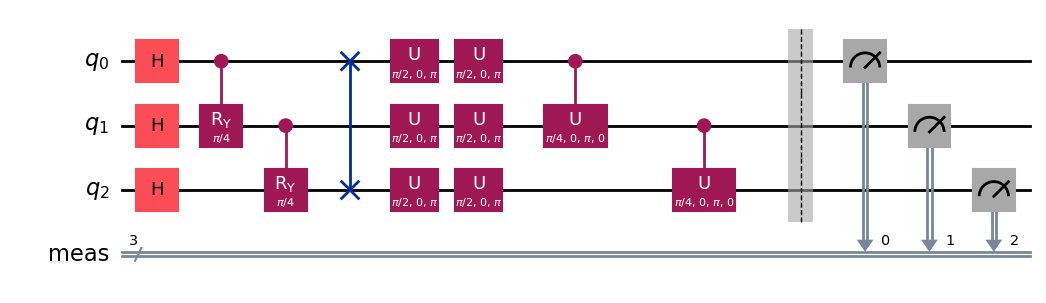

In [35]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RYGate
import numpy as np

def ae_circuit(num_qubits):
    # Initialize a quantum circuit with num_qubits
    qc = QuantumCircuit(num_qubits)
    
    # Step 1: Apply Hadamard to all qubits (Q Operators)
    qc.h(range(num_qubits))
    
    # Step 2: Controlled Ry gates for each qubit pair
    for i in range(num_qubits - 1):
        qc.cry(np.pi/4, i, i+1)  # Adjust the angle as per the problem requirements
    
    # Step 3: SWAP gates
    qc.swap(0, 2)  # Swap between qubit 0 and qubit 2 as per the diagram
    
    # Step 4: Inverse QFT using the U gate instead of U2/U3
    # U2(φ, λ) is replaced by U(π/2, φ, λ)
    # U3(θ, φ, λ) is replaced by U(θ, φ, λ)
    for i in range(num_qubits):
        qc.u(np.pi/2, 0, np.pi, i)  # Equivalent of U2 gate
        qc.u(np.pi/2, 0, np.pi, i)  # Equivalent of U3 gate
    
    # Add controlled gates similar to the QFT structure
    for i in range(num_qubits - 1):
        control_qubit = i  # Define control qubit
        target_qubit = i+1  # Define target qubit
        theta = np.pi / 4  # Example rotation angle around X-axis
        phi = 0  # Rotation around Z-axis before X rotation
        lam = np.pi  # Rotation around Z-axis after X rotation
        gamma = 0  # Global phase (optional)
        
        # Apply the controlled U gate
        qc.cu(theta, phi, lam, gamma, control_qubit, target_qubit) # Controlled U gate
    
    # Step 5: Measurement (optional)
    qc.measure_all()

    return qc

# Example use
qc = ae_circuit(3)
qc.draw('mpl')



In [43]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 
from qiskit_ibm_runtime import QiskitRuntimeService 

service=QiskitRuntimeService()
backend=service.least_busy(operational=True)
print(backend.name)

pm=generate_preset_pass_manager(optimization_level=3,backend=backend)
isa_circ=pm.run(qc)

ibm_sherbrooke


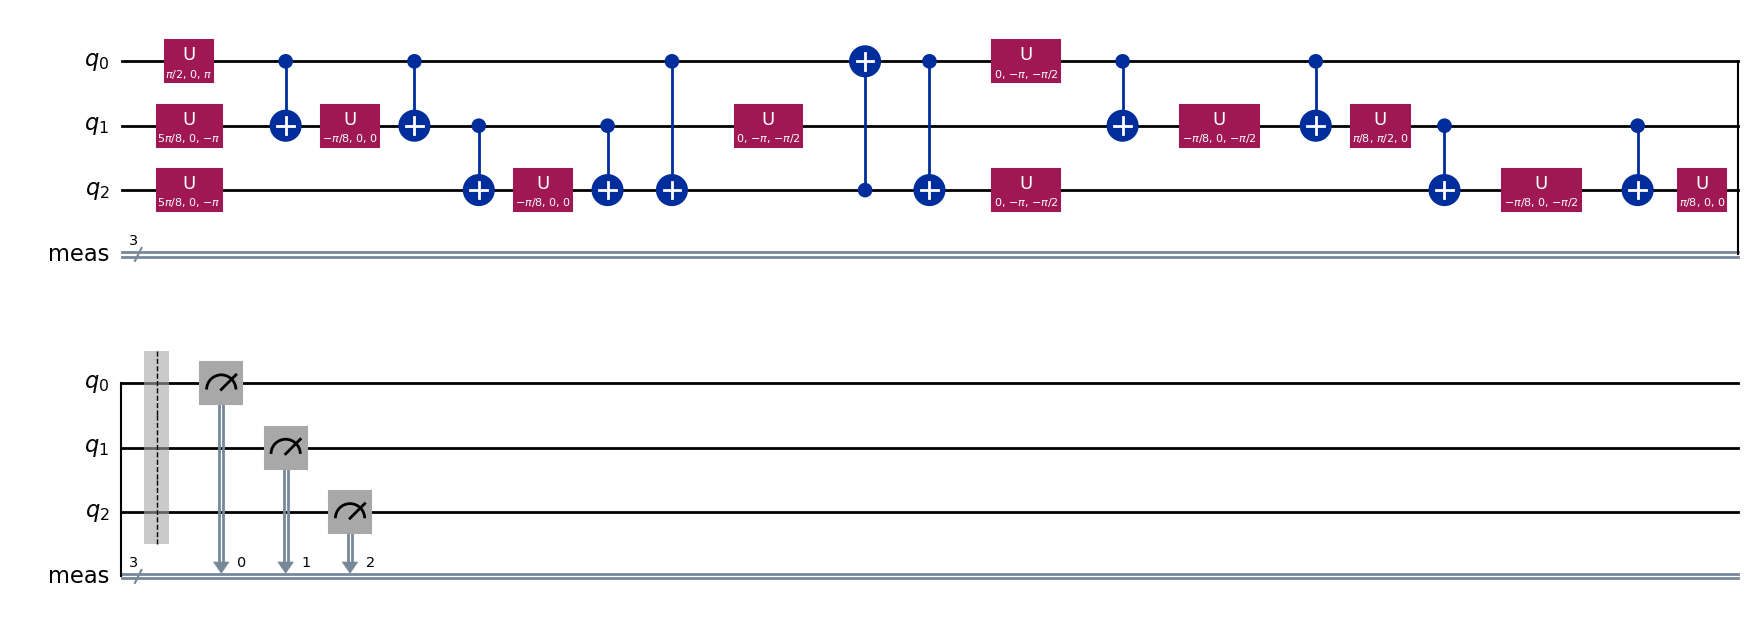

In [39]:
transpiled_circuit.decompose().draw(output="mpl")

In [44]:


# Analyze T-gates in the circuit
resource_estimation = ResourceEstimation()
pass_manager = PassManager(resource_estimation)
pass_manager.run(isa_circ)

# Output resource count
print("Number of T-gates:", resource_estimation.property_set['count_t'])

Number of T-gates: None


In [45]:
resource_estimation.property_set

{'depth': 27,
 'width': 130,
 'size': 46,
 'count_ops': {'rz': 19,
  'sx': 17,
  'ecr': 5,
  'x': 1,
  'barrier': 1,
  'measure': 3},
 'num_tensor_factors': 125,
 'num_qubits': 127}

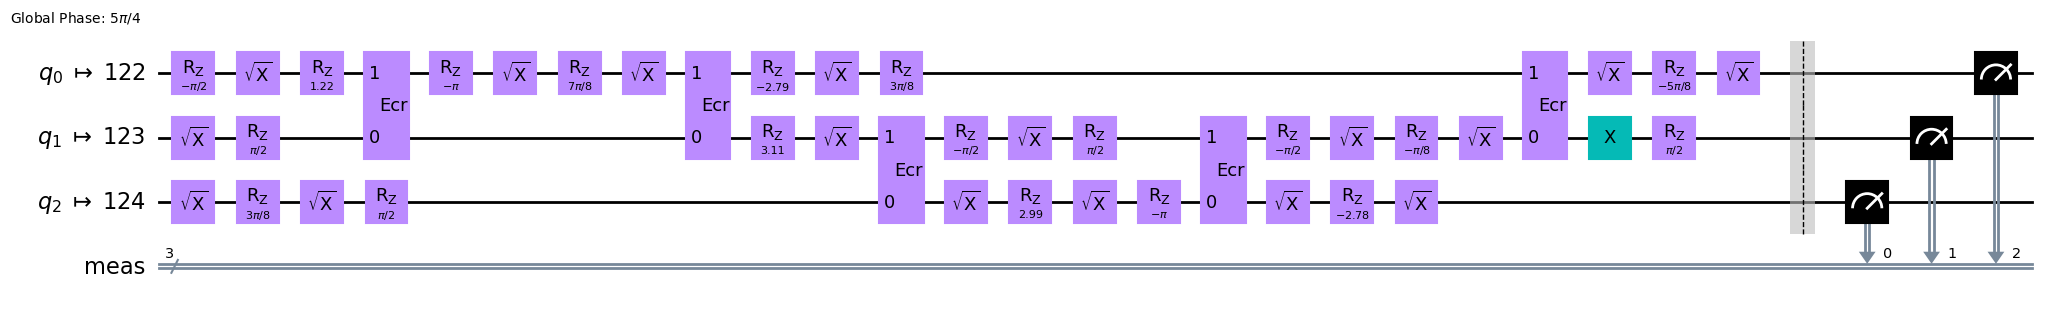

In [47]:
isa_circ.draw(fold=-1,output="mpl",idle_wires=False,style="clifford")

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import DraperQFTAdder
from qiskit.circuit.library import U1Gate, U2Gate, U3Gate

In [4]:
K = 3  # Example strike price (in binary: '11')
S_T = 7

In [32]:
def prepare_input_circuit(num_state_qubits):
    """Prepare the input circuit for the asset price (S_T) and strike price (K)."""
    # Create quantum registers
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out
    summation = ClassicalRegister(num_state_qubits + 1, 'sum')  # Measurement result

    qc = QuantumCircuit(summand1, summand2, carry_out, summation)

    # Encode S_T (in binary) - e.g., 7 = 111
    qc.x([summand1[0], summand1[1], summand1[2]])  # |111>

    # Encode K (in binary) - e.g., 3 = 11
    qc.x([summand2[1], summand2[2]])  # |011>
    
    return qc

In [35]:
def arithmetic_operations_circuit(num_state_qubits):
    """Construct the arithmetic operations for S_T - K using DraperQFTAdder."""
    # Create quantum registers
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out
    summation = ClassicalRegister(num_state_qubits + 1, 'sum')  # Measurement result

    # Create the circuit
    qc = QuantumCircuit(summand1, summand2, carry_out, summation)

    # Add the DraperQFTAdder
    adder = DraperQFTAdder(num_state_qubits, kind='half', name='Draper_Adder')

    # Append the adder
    qc.append(adder, summand1[:] + summand2[:] + carry_out[:])

    # Measure the result
    qc.measure(summand2[:] + carry_out[:], summation)

    return qc

In [36]:
def max_function_circuit(num_state_qubits):
    """Implement the max function to determine max(S_T - K, 0)."""
    # Create quantum registers
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out
    summation = ClassicalRegister(num_state_qubits + 1, 'sum')  # Measurement result
    ancilla = QuantumRegister(1, 'ancilla')              # Ancilla for comparison

    # Create the circuit
    qc = QuantumCircuit(summand1, summand2, carry_out, summation, ancilla)

    # Perform arithmetic operations to calculate S_T - K
    arithmetic_circuit = arithmetic_operations_circuit(num_state_qubits)
    qc = qc.compose(arithmetic_circuit)

    # Comparison logic: Check if result (in first qubit) is >= 0
    qc.cx(summation[0], ancilla[0])  # If the first qubit is 1 (result is negative)
    qc.x(ancilla[0])  # Prepare to set ancilla to 0 if the first qubit is negative

    # Measure the ancilla to determine if max function outputs 0 or S_T - K
    qc.measure(ancilla[0], summation[-1])  # Store in last bit of summation register

    return qc

def discounting_circuit(num_state_qubits, discount_rate):
    """Implement a discounting operation."""
    qc = QuantumCircuit(num_state_qubits)
    # For simplicity, we will just rotate based on the discount rate
    qc.rx(discount_rate, range(num_state_qubits))
    return qc

In [37]:
def comprehensive_arithmetic_circuit(num_state_qubits, discount_rate):
    """Construct a comprehensive arithmetic circuit for European call option pricing."""
    # Initialize the circuit
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out
    summation = ClassicalRegister(num_state_qubits + 1, 'sum')  # Measurement result
    ancilla = QuantumRegister(1, 'ancilla')              # Ancilla for comparison

    qc = QuantumCircuit(summand1, summand2, carry_out, summation, ancilla)

    # Step 1: Prepare input (S_T and K)
    input_circuit = prepare_input_circuit(num_state_qubits)
    qc = qc.compose(input_circuit)

    # Step 2: Perform arithmetic operations (S_T - K)
    arithmetic_circuit = arithmetic_operations_circuit(num_state_qubits)
    qc = qc.compose(arithmetic_circuit)

    # Step 3: Implement the max function
    max_circuit = max_function_circuit(num_state_qubits)
    qc = qc.compose(max_circuit)

    # Step 4: Implement discounting
    discount_circuit = discounting_circuit(num_state_qubits, discount_rate)
    qc = qc.compose(discount_circuit)

    return qc


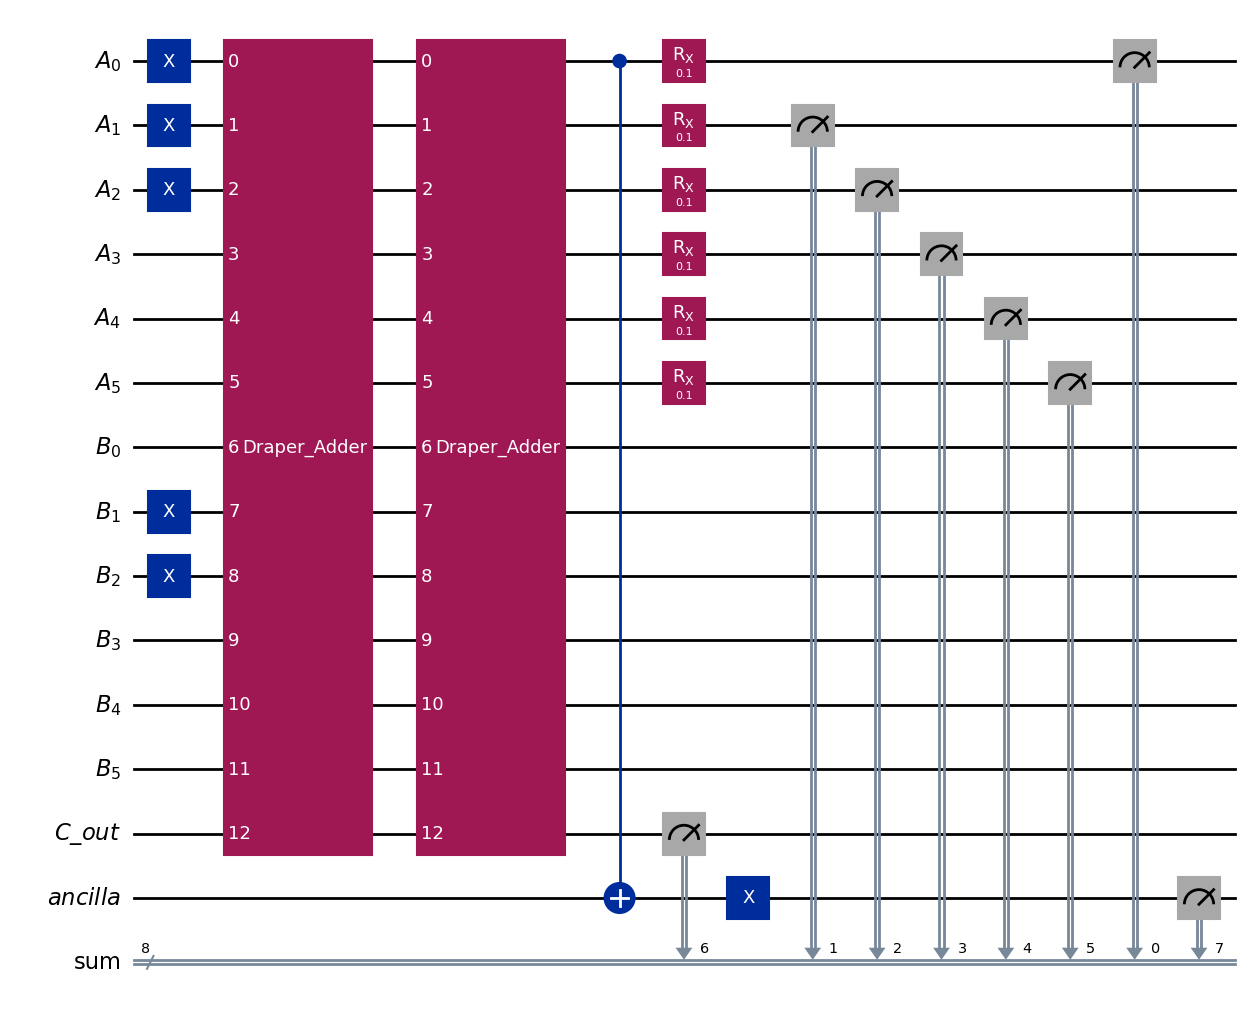

In [41]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import DraperQFTAdder

# Constants
K = 3  # Example strike price (in binary: '11')
S_T = 7  # Example asset price (in binary: '111')

def prepare_input_circuit(num_state_qubits):
    """Prepare the input circuit for the asset price (S_T) and strike price (K)."""
    # Create quantum registers
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out

    qc = QuantumCircuit(summand1, summand2, carry_out)

    # Encode S_T (in binary) - e.g., 7 = 111
    qc.x([summand1[0], summand1[1], summand1[2]])  # |111>

    # Encode K (in binary) - e.g., 3 = 11
    qc.x([summand2[1], summand2[2]])  # |011>
    
    return qc

def arithmetic_operations_circuit(num_state_qubits):
    """Construct the arithmetic operations for S_T - K using DraperQFTAdder."""
    # Create quantum registers
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out

    # Create the circuit
    qc = QuantumCircuit(summand1, summand2, carry_out)

    # Add the DraperQFTAdder
    adder = DraperQFTAdder(num_state_qubits, kind='half', name='Draper_Adder')

    # Append the adder
    qc.append(adder, summand1[:] + summand2[:] + carry_out[:])

    return qc

def max_function_circuit(num_state_qubits):
    """Implement the max function to determine max(S_T - K, 0)."""
    # Create quantum registers
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out
    ancilla = QuantumRegister(1, 'ancilla')              # Ancilla for comparison

    # Create the circuit
    qc = QuantumCircuit(summand1, summand2, carry_out, ancilla)

    # Perform arithmetic operations to calculate S_T - K
    arithmetic_circuit = arithmetic_operations_circuit(num_state_qubits)
    qc = qc.compose(arithmetic_circuit)

    # Comparison logic: Check if result (in first qubit) is >= 0
    qc.cx(summand1[0], ancilla[0])  # Compare results with ancilla
    qc.x(ancilla[0])  # Prepare to set ancilla to 0 if the first qubit is negative

    return qc

def discounting_circuit(num_state_qubits, discount_rate):
    """Implement a discounting operation."""
    qc = QuantumCircuit(num_state_qubits)
    # For simplicity, we will just rotate based on the discount rate
    qc.rx(discount_rate, range(num_state_qubits))
    return qc

def comprehensive_arithmetic_circuit(num_state_qubits, discount_rate):
    """Construct a comprehensive arithmetic circuit for European call option pricing."""
    # Create quantum registers
    summand1 = QuantumRegister(num_state_qubits, 'A')  # For S_T
    summand2 = QuantumRegister(num_state_qubits, 'B')  # For K
    carry_out = QuantumRegister(1, 'C_out')             # Carry out
    ancilla = QuantumRegister(1, 'ancilla')              # Ancilla for comparison

    # The total number of classical bits should reflect the number of qubits measured
    summation = ClassicalRegister(num_state_qubits + 2, 'sum')  # +2 for carry_out and ancilla

    qc = QuantumCircuit(summand1, summand2, carry_out, summation, ancilla)

    # Step 1: Prepare input (S_T and K)
    input_circuit = prepare_input_circuit(num_state_qubits)
    qc = qc.compose(input_circuit)

    # Step 2: Perform arithmetic operations (S_T - K)
    arithmetic_circuit = arithmetic_operations_circuit(num_state_qubits)
    qc = qc.compose(arithmetic_circuit)

    # Step 3: Implement the max function
    max_circuit = max_function_circuit(num_state_qubits)
    qc = qc.compose(max_circuit)

    # Step 4: Implement discounting
    discount_circuit = discounting_circuit(num_state_qubits, discount_rate)
    qc = qc.compose(discount_circuit)

    # Measure the final results
    # Ensure correct qubits are being measured into classical bits
    qc.measure(summand1[:] + carry_out[:] + ancilla[:], summation)

    return qc

# Example of constructing the comprehensive circuit
num_state_qubits = 6  # Total qubits for S_T and K + additional for comparison
discount_rate = 0.1  # Example discount rate
circuit = comprehensive_arithmetic_circuit(num_state_qubits, discount_rate)
circuit.draw('mpl')


In [57]:
from qiskit.circuit.library import PolynomialPauliRotations
def qsp_circ(num_qubits,degree):
    qc=QuantumCircuit(num_qubits+1)
    coeffs=[1]*(degree)
    poly_approx=PolynomialPauliRotations(num_qubits,coeffs)
    qc.append(poly_approx,range(num_qubits+1))
    return qc

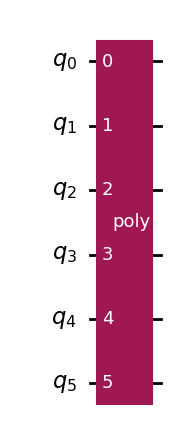

In [59]:
circ=qsp_circ(5,5)
circ.decompose().draw(output="mpl")

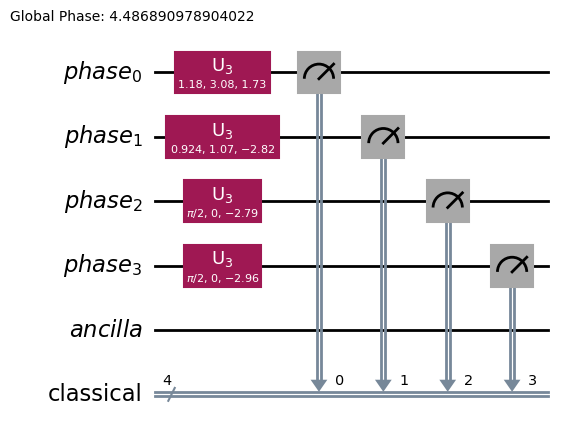

In [199]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import RXXGate,RYGate

def create_phase_encoding_circuit(num_qubits, S_T, K):
    """
    Create a phase encoding circuit for the asset price (S_T) and strike price (K).
    """
    qc = QuantumCircuit(num_qubits)
    
    # Encode S_T and K into phases
    phase_S_T = 2 * np.pi * S_T / (2**num_qubits)
    phase_K = 2 * np.pi * K / (2**num_qubits)
    
    # Create the state |0> + |1> + ... + |(2**num_qubits - 1)>
    qc.h(range(num_qubits))  # Apply Hadamard to create superposition
    
    # Apply phase rotations
    qc.rz(phase_S_T, 0)  # For S_T
    qc.rz(phase_K, 1)    # For K
    
    return qc

def create_qsp_circuit(num_qubits, S_T, K, r, T):
    """
    Create a Quantum Signal Processing circuit to estimate the European call price.
    """
    # Calculate the value needed for the phase rotations
    discount_factor = np.exp(-r * T)
    
    # Create quantum registers
    phase_register = QuantumRegister(num_qubits, 'phase')
    ancilla_register = QuantumRegister(1, 'ancilla')
    classical_register = ClassicalRegister(num_qubits, 'classical')

    qc = QuantumCircuit(phase_register, ancilla_register, classical_register)

    # Step 1: Phase encoding for S_T and K
    qc = qc.compose(create_phase_encoding_circuit(num_qubits, S_T, K))

    # Step 2: Apply QSP rotations (for a simple example, we will just use RX gates)
    num_rotations = 4  # Define how many rotations you want to apply
    for i in range(num_rotations):
        # Apply rotation to control the angle based on discount_factor
        qc.rx(np.pi * discount_factor / (2 ** (i + 1)), phase_register[i % num_qubits])

    # Step 3: Measurement
    qc.measure(phase_register, classical_register)
    
    return qc

# Example of creating the QSP circuit
num_qubits = 4  # Number of qubits for state representation
S_T = 7        # Asset price
K = 3          # Strike price
r = 0.1        # Discount rate
T = 1          # Time to maturity

qsp_circuit = create_qsp_circuit(num_qubits, S_T, K, r, T)
transpiled_circuit = transpile(qsp_circuit, optimization_level=3)
transpiled_circuit.draw('mpl')


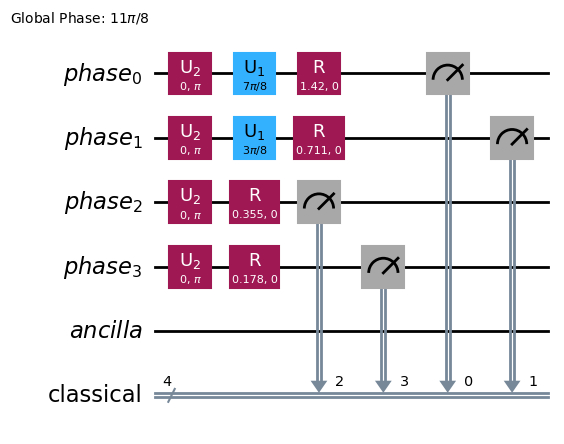

In [62]:
qsp_circuit.decompose().draw(output="mpl")

In [66]:
from qiskit_aer import AerSimulator

In [77]:
from qiskit_ibm_runtime import QiskitRuntimeService 
service=QiskitRuntimeService()
backend=service.least_busy(operational=True)
print(backend.name)
print(backend.basis_gates)

ibm_brisbane
['ecr', 'id', 'rz', 'sx', 'x']


In [78]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 
pm=generate_preset_pass_manager(backend=backend,optimization_level=3)

In [79]:
def get_circuit_depths(num_qubits_list):
    global S_T
    global K 
    global r 
    global T
    qsp_depths = []
    arithmetic_depths = []

    for num_qubits in num_qubits_list:
        # QSP Circuit
        
        qsp_circuit = create_qsp_circuit(num_qubits, S_T, K, r, T)
        qc_qsp_transpiled = pm.run(qsp_circuit)
        qsp_depths.append(qc_qsp_transpiled.depth())

        # Arithmetic Circuit
        num_state_qubits = 6  # Total qubits for S_T and K + additional for comparison
        discount_rate = 0.1  # Example discount rate
        qc_arithmetic = comprehensive_arithmetic_circuit(num_state_qubits, discount_rate)
        qc_arithmetic_transpiled =pm.run(qc_arithmetic)
        arithmetic_depths.append(qc_arithmetic_transpiled.depth())

    return qsp_depths, arithmetic_depths

In [80]:
def plot_depths(num_qubits_list, qsp_depths, arithmetic_depths):
    plt.figure(figsize=(10, 6))
    plt.plot(num_qubits_list, qsp_depths, label="QSP Circuit Depth", marker='o')
    plt.plot(num_qubits_list, arithmetic_depths, label="Arithmetic Circuit Depth", marker='s')
    
    plt.xlabel("Number of Qubits")
    plt.ylabel("Circuit Depth")
    plt.title("Circuit Depth vs Number of Qubits for QSP and Standard Quantum Arithmetic")
    plt.legend()
    plt.grid(True)
    plt.show()

In [73]:
import matplotlib.pyplot as plt

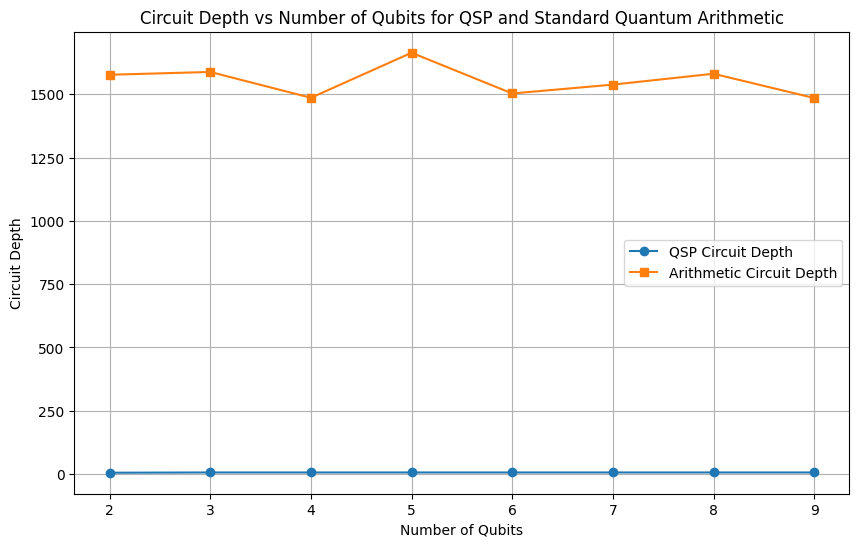

In [81]:
num_qubits_list = list(range(2, 10))  # Example: 2 to 14 qubits
max_degree = 3  # Degree of the polynomial for QSP

# Get the depths
qsp_depths, arithmetic_depths = get_circuit_depths(num_qubits_list)

# Plot the results
plot_depths(num_qubits_list, qsp_depths, arithmetic_depths)

In [82]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RZGate
from scipy.optimize import minimize

In [83]:
def f(x):
    """ Example function: f(x) = e^(-x) * max(S_T - K, 0) in normalized form [0, 1] """
    S_T = 7  # Example S_T
    K = 3    # Example K
    payoff = np.maximum(S_T - K, 0)
    return np.exp(-x) * payoff


In [84]:
def chebyshev_poly(n, x):
    """ Compute the Chebyshev polynomial T_n(x) """
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return 2 * x * chebyshev_poly(n-1, x) - chebyshev_poly(n-2, x)

In [85]:
def find_coefficients(degree, M):
    """ Minimize the max error of approximation using Chebyshev polynomials. """
    # Generate Chebyshev grid points
    xj = [0.5 * (1 - np.cos(j * np.pi / (M - 1))) for j in range(M)]
    
    # Define the optimization problem
    def objective(c):
        """ Maximize |f(xj) - P(xj)| """
        max_error = float('-inf')
        for j in range(M):
            P_xj = sum(c[k] * chebyshev_poly(2*k, xj[j]) for k in range(degree//2 + 1))
            max_error = max(max_error, abs(f(xj[j]) - P_xj))
        return max_error
    
    # Initial guess for coefficients
    initial_guess = np.zeros(degree//2 + 1)
    result = minimize(objective, initial_guess, method='SLSQP')
    
    return result.x

In [91]:
def create_qsp_circuit(num_qubits, coefficients):
    """ Create a QSP circuit based on the provided coefficients. """
    qc = QuantumCircuit(num_qubits)
    print(coefficients)
    
    # Apply RZ rotations according to coefficients
    for k, c_k in enumerate(coefficients):
        print(c_k)
        angle = 2 * np.arccos(c_k)  # Angle for RZ gate
        qc.rz(angle, k % num_qubits)  # Apply to corresponding qubit
        
    # Assume we apply some additional operations depending on the QSP method
    return qc


In [103]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister
from scipy.optimize import minimize

# Function to approximate
def f(x):
    """ Example function: f(x) = e^(-x) * max(S_T - K, 0) in normalized form [0, 1] """
    S_T = 7  # Example S_T
    K = 3    # Example K
    payoff = np.maximum(S_T - K, 0)
    return np.exp(-x) * payoff

# Chebyshev polynomial evaluation
def chebyshev_poly(n, x):
    """ Compute the Chebyshev polynomial T_n(x) """
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return 2 * x * chebyshev_poly(n - 1, x) - chebyshev_poly(n - 2, x)

# Optimization to find the coefficients ck
def find_coefficients(degree, M):
    """ Minimize the max error of approximation using Chebyshev polynomials. """
    # Generate Chebyshev grid points
    xj = [0.5 * (1 - np.cos(j * np.pi / (M - 1))) for j in range(M)]
    
    # Define the optimization problem
    def objective(c):
        """ Maximize |f(xj) - P(xj)| """
        max_error = float('-inf')
        for j in range(M):
            P_xj = sum(c[k] * chebyshev_poly(2 * k, xj[j]) for k in range(degree // 2 + 1))
            max_error = max(max_error, abs(f(xj[j]) - P_xj))
        return max_error
    
    # Initial guess for coefficients
    initial_guess = np.zeros(degree // 2 + 1)
    result = minimize(objective, initial_guess, method='SLSQP')
    
    # Check optimization result
    if not result.success:
        print("Optimization failed:", result.message)
        print("Returning default coefficients.")
        return np.zeros(degree // 2 + 1)  # Return zero coefficients if optimization fails
    
    print("Optimized coefficients:", result.x)
    return result.x

def create_qsp_circuit(num_qubits, coefficients):
    """ Create a QSP circuit based on the provided coefficients. """
    qc = QuantumCircuit(num_qubits)
    
    # Apply RZ rotations according to coefficients
    for k, c_k in enumerate(coefficients):
        # Clip the coefficient to the range [-1, 1]
        c_k = np.clip(c_k, -1, 1)
        
        # Calculate angle for RZ gate
        if c_k >= -1 and c_k <= 1:
            angle = 2 * np.arccos(c_k)  # Angle for RZ gate
            qc.rz(angle, k % num_qubits)  # Apply to corresponding qubit
        else:
            print(f"Invalid coefficient at index {k}: {c_k} - Skipping.")
        
    return qc

# Main parameters
degree = 20  # Degree of Chebyshev polynomial
M = 25      # Number of grid points
num_qubits = degree // 2 + 1  # Number of qubits needed

# Step 1: Find coefficients
coefficients = find_coefficients(degree, M)

# Step 2: Create QSP circuit
qsp_circuit = create_qsp_circuit(num_qubits, coefficients)

# Step 3: Create classical register to measure the output
classical_register = ClassicalRegister(num_qubits, 'classical')
qsp_circuit.add_register(classical_register)

# Measure the qubits
qsp_circuit.measure(range(num_qubits), classical_register)

# Display the circuit
try:
    qsp_circuit.draw('mpl')
except ValueError as e:
    print("Error while drawing the circuit:", e)


Optimized coefficients: [ 2.20639324 -0.98351606  0.30783276 -0.14481587  0.08123461 -0.06295746
  0.02313334 -0.03047684  0.04178911 -0.02263379  0.03613415]


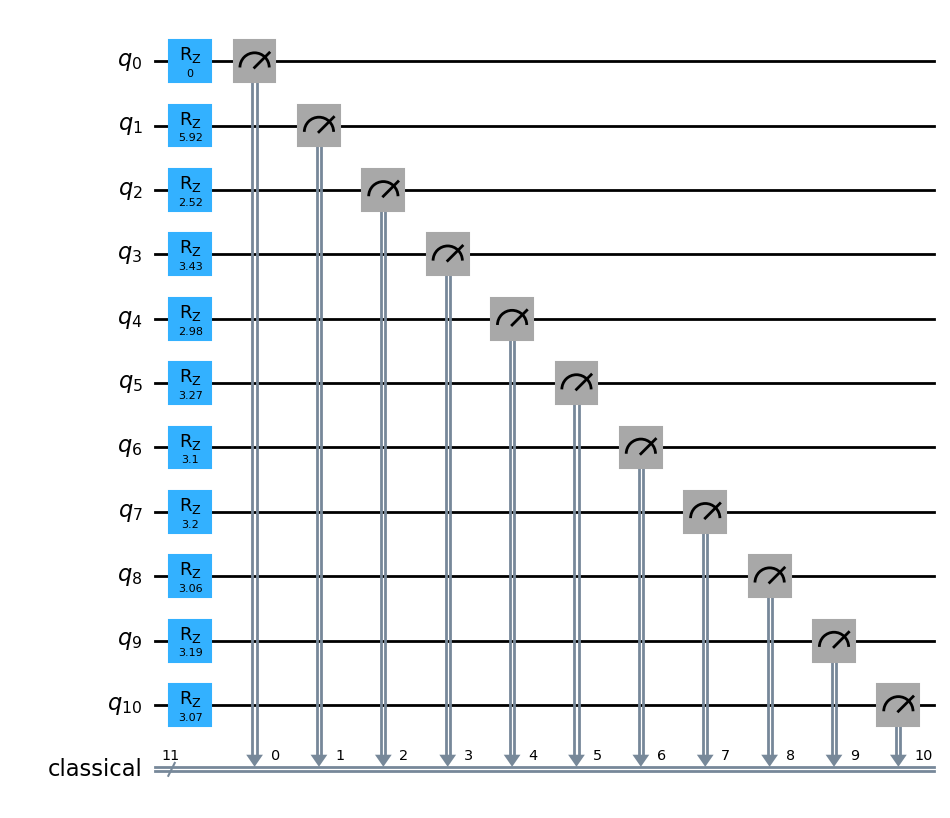

In [104]:
qsp_circuit.draw('mpl')

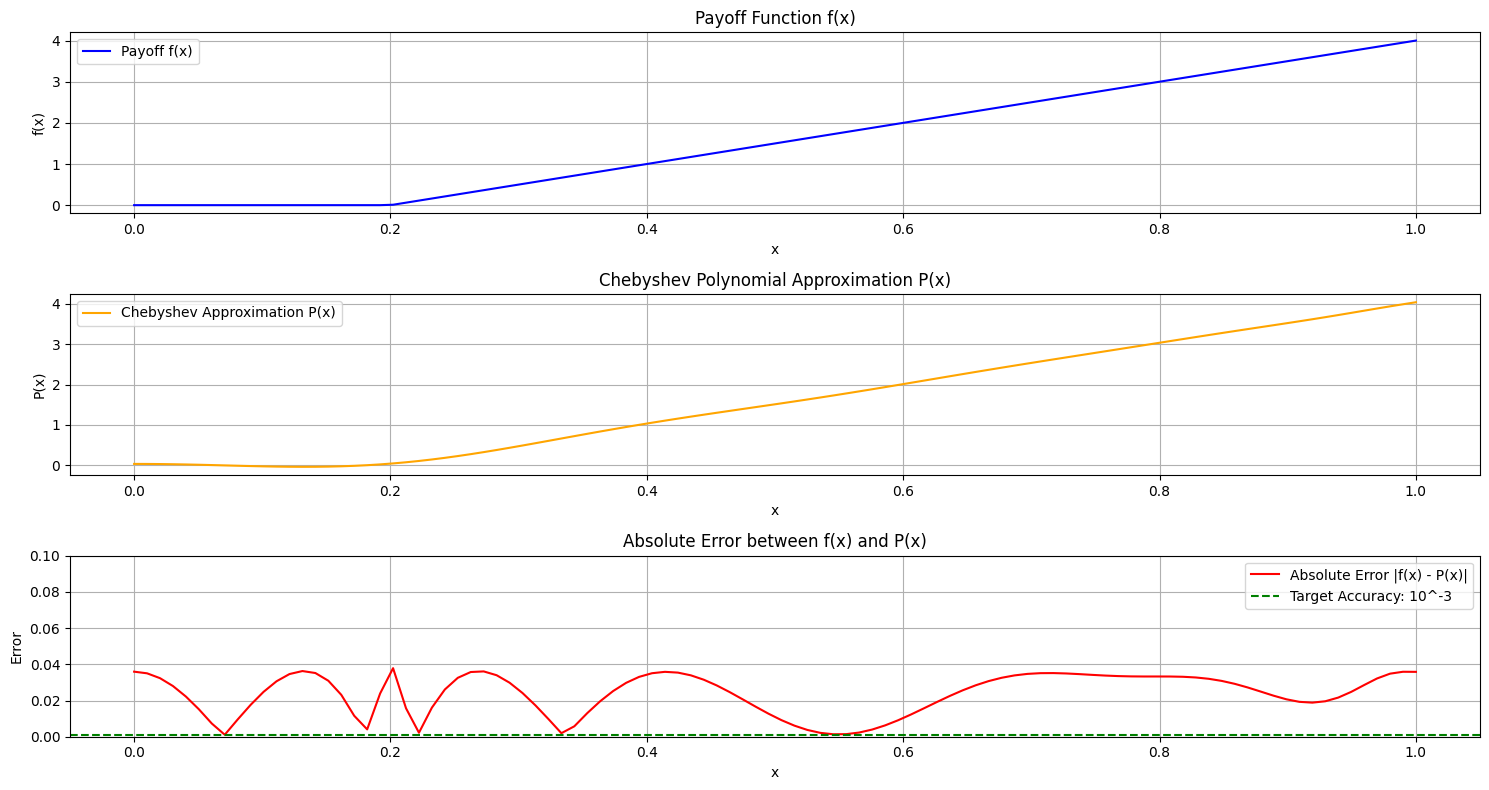

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the parameters for the autocallable contract
p = 5  # payoff multiplier
s = 2 * p  # strike price
K_T = 1  # knockout price

# Define the payoff function f(x)
def f(x):
    """ Payoff function for the autocallable contract """
    return np.maximum(0, (p * x - K_T))  # Payoff formula

# Chebyshev polynomial evaluation
def chebyshev_poly(n, x):
    """ Compute the Chebyshev polynomial T_n(x) using the recurrence relation """
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return 2 * x * chebyshev_poly(n - 1, x) - chebyshev_poly(n - 2, x)

# Optimization to find the coefficients ck for Chebyshev approximation
def find_coefficients(f, degree, num_points):
    """ Find coefficients ck for Chebyshev polynomial approximation """
    xj = [0.5 * (1 - np.cos(j * np.pi / (num_points - 1))) for j in range(num_points)]
    
    # Define the optimization problem
    def objective(c):
        """ Maximize |f(xj) - P(xj)| """
        max_error = float('-inf')
        for j in range(num_points):
            P_xj = sum(c[k] * chebyshev_poly(2 * k, xj[j]) for k in range(degree // 2 + 1))
            max_error = max(max_error, abs(f(xj[j]) - P_xj))
        return max_error
    
    # Initial guess for coefficients
    initial_guess = np.zeros(degree // 2 + 1)
    result = minimize(objective, initial_guess, method='SLSQP')
    
    if not result.success:
        print("Optimization failed:", result.message)
        return np.zeros(degree // 2 + 1)  # Return zero coefficients if optimization fails
    
    return result.x

# Parameters
degree = 20  # Degree of Chebyshev polynomial
num_points = 100  # Number of grid points

# Find coefficients for Chebyshev polynomial approximation
coefficients = find_coefficients(f, degree, num_points)

# Generate x values
x_values = np.linspace(0, 1, 100)
f_values = f(x_values)

# Calculate Chebyshev polynomial approximation P(x)
P_values = [sum(coefficients[k] * chebyshev_poly(2 * k, x) for k in range(degree // 2 + 1)) for x in x_values]

# Calculate absolute error
absolute_error = np.abs(f_values - P_values)

# Plot the results
plt.figure(figsize=(15, 8))

# Plot f(x)
plt.subplot(3, 1, 1)
plt.plot(x_values, f_values, label='Payoff f(x)', color='blue')
plt.title('Payoff Function f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.legend()

# Plot P(x)
plt.subplot(3, 1, 2)
plt.plot(x_values, P_values, label='Chebyshev Approximation P(x)', color='orange')
plt.title('Chebyshev Polynomial Approximation P(x)')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.grid()
plt.legend()

# Plot absolute error
plt.subplot(3, 1, 3)
plt.plot(x_values, absolute_error, label='Absolute Error |f(x) - P(x)|', color='red')
plt.axhline(y=1e-3, color='green', linestyle='--', label='Target Accuracy: 10^-3')
plt.title('Absolute Error between f(x) and P(x)')
plt.xlabel('x')
plt.ylabel('Error')
plt.ylim(0, 0.1)  # Adjust the y-limit for better visibility
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [107]:
import numpy as np
from qiskit import QuantumCircuit,transpile
from qiskit_aer  import AerSimulator
from qiskit.circuit.library import QFT

def initialize_multivariate_normal(num_assets, timesteps, num_qubits):
    """ Initialize a multivariate normal distribution on a quantum circuit. """
    qc = QuantumCircuit(num_qubits)
    # Step 1: Create superposition for log returns
    for i in range(num_qubits):
        qc.h(i)  # Apply Hadamard to create equal superposition for log returns
    return qc


In [108]:
def standard_reparameterization(qc, log_returns_qubits, payoff_qubits, S0, barrier):
    """ Standard reparameterization method for payoff calculation. """
    num_log_returns = len(log_returns_qubits)
    
    # Step 2: Compute the asset price S_t = S0 * exp(r_t)
    # This part requires quantum arithmetic to calculate the exponential of log returns
    # For simplicity, we'll assume the exponential calculation is done here.
    
    for i in range(num_log_returns):
        # Example: Apply an approximation of the exponential
        qc.ry(np.pi/4, log_returns_qubits[i])  # Simplified version of the exponential function

    # Step 3: Compare to barrier and trigger payoff
    # Use ancilla qubits to store the comparison results
    for i in range(len(payoff_qubits)):
        qc.cx(log_returns_qubits[i], payoff_qubits[i])

    return qc


In [109]:
def qsp_method(qc, log_returns_qubits, payoff_qubits, chebyshev_coefficients, S0, barrier):
    """ QSP-based method for payoff calculation using Chebyshev polynomial approximation. """
    num_log_returns = len(log_returns_qubits)
    
    # Step 2: Apply QSP transformation using Chebyshev polynomials
    # This applies the QSP approximation for the exponential function in payoff calculation.
    
    for i in range(num_log_returns):
        # Apply a QSP phase rotation based on the Chebyshev coefficients
        # (Here, we simplify the Chebyshev polynomial application)
        qc.ry(chebyshev_coefficients[i] * np.pi, log_returns_qubits[i])

    # Step 3: Compare to barrier and trigger payoff
    # This step is the same as the standard method, using ancilla qubits for comparisons.
    for i in range(len(payoff_qubits)):
        qc.cx(log_returns_qubits[i], payoff_qubits[i])

    return qc


In [118]:
# Parameters
num_assets = 3
timesteps = 3
num_qubits = timesteps + num_assets  # Qubits for log returns and payoff comparison
payoff_qubits = [0, 1]  # Adjusted example payoff qubits (within range)
log_returns_qubits = [2, 3,4]  # Adjusted log return qubits (within range)
S0 = 100
barrier = 1.2
chebyshev_coefficients = [0.5, 0.3, 0.2]  # Example Chebyshev coefficients

# Initialize the quantum circuits
qc_standard = initialize_multivariate_normal(num_assets, timesteps, num_qubits)
qc_qsp = initialize_multivariate_normal(num_assets, timesteps, num_qubits)

# Apply the standard reparameterization method
qc_standard = standard_reparameterization(qc_standard, log_returns_qubits, payoff_qubits, S0, barrier)
depth_standard = qc_standard.depth()

# Apply the QSP method
qc_qsp = qsp_method(qc_qsp, log_returns_qubits, payoff_qubits, chebyshev_coefficients, S0, barrier)
depth_qsp = qc_qsp.depth()

# Print the depths
print(f"Depth of the standard reparameterization circuit: {depth_standard}")
print(f"Depth of the QSP circuit: {depth_qsp}")


Depth of the standard reparameterization circuit: 3
Depth of the QSP circuit: 3


In [119]:
qc_qsp.draw()

┌───┐             ┌───┐     
q_0: ┤ H ├─────────────┤ X ├─────
     ├───┤             └─┬─┘┌───┐
q_1: ┤ H ├───────────────┼──┤ X ├
     ├───┤ ┌─────────┐   │  └─┬─┘
q_2: ┤ H ├─┤ Ry(π/2) ├───■────┼──
     ├───┤┌┴─────────┴┐       │  
q_3: ┤ H ├┤ Ry(3π/10) ├───────■──
     ├───┤└┬─────────┬┘          
q_4: ┤ H ├─┤ Ry(π/5) ├───────────
     ├───┤ └─────────┘           
q_5: ┤ H ├───────────────────────
     └───┘

In [120]:
qc_standard.draw()

┌───┐           ┌───┐     
q_0: ┤ H ├───────────┤ X ├─────
     ├───┤           └─┬─┘┌───┐
q_1: ┤ H ├─────────────┼──┤ X ├
     ├───┤┌─────────┐  │  └─┬─┘
q_2: ┤ H ├┤ Ry(π/4) ├──■────┼──
     ├───┤├─────────┤       │  
q_3: ┤ H ├┤ Ry(π/4) ├───────■──
     ├───┤├─────────┤          
q_4: ┤ H ├┤ Ry(π/4) ├──────────
     ├───┤└─────────┘          
q_5: ┤ H ├─────────────────────
     └───┘

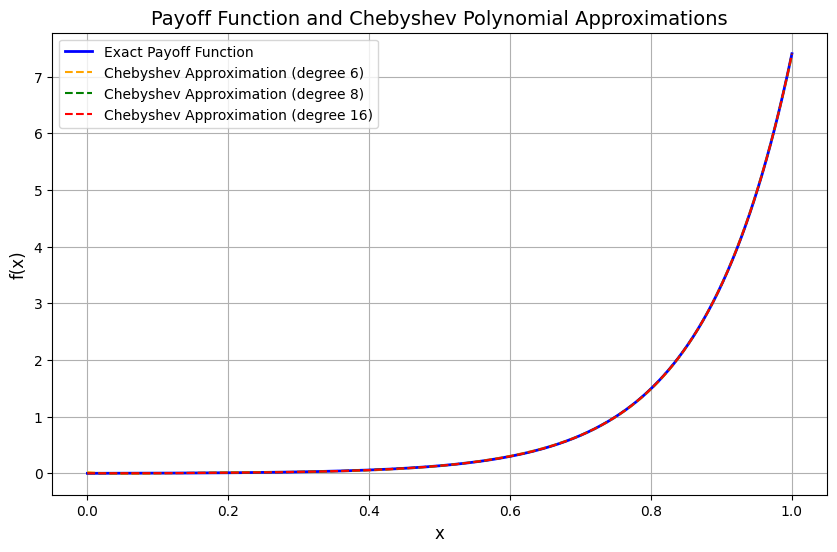

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import Chebyshev

# Define the payoff function for a European call option (f(x) as in Eq. 35)
def payoff_function(x, S0, K, p):
    fmax = S0 * np.exp(2 * p) - K
    return np.maximum(0, S0 * np.exp(x * 2**p) - K) / fmax

# Generate Chebyshev polynomial approximation
def chebyshev_approximation(degree, x):
    # Fit Chebyshev polynomial to the payoff function
    coefs = np.polynomial.chebyshev.chebfit(x, payoff_function(x, S0, K, p), degree)
    poly = Chebyshev(coefs)
    return poly(x)

# Parameters
S0 = 100  # Initial asset price
K = 100   # Strike price
p = 3     # Scaling factor

# Define x in the range [0, 1] for the payoff function
x = np.linspace(0, 1, 1000)

# Compute the exact payoff function values
f_x = payoff_function(x, S0, K, p)

# Compute Chebyshev polynomial approximations for degrees 6, 8, 16
P6 = chebyshev_approximation(6, x)
P8 = chebyshev_approximation(8, x)
P16 = chebyshev_approximation(16, x)

# Plot the function and its polynomial approximations
plt.figure(figsize=(10, 6))
plt.plot(x, f_x, label='Exact Payoff Function', color='blue', lw=2)
plt.plot(x, P6, label='Chebyshev Approximation (degree 6)', linestyle='--', color='orange')
plt.plot(x, P8, label='Chebyshev Approximation (degree 8)', linestyle='--', color='green')
plt.plot(x, P16, label='Chebyshev Approximation (degree 16)', linestyle='--', color='red')

# Add labels and legend
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.title('Payoff Function and Chebyshev Polynomial Approximations', fontsize=14)
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()


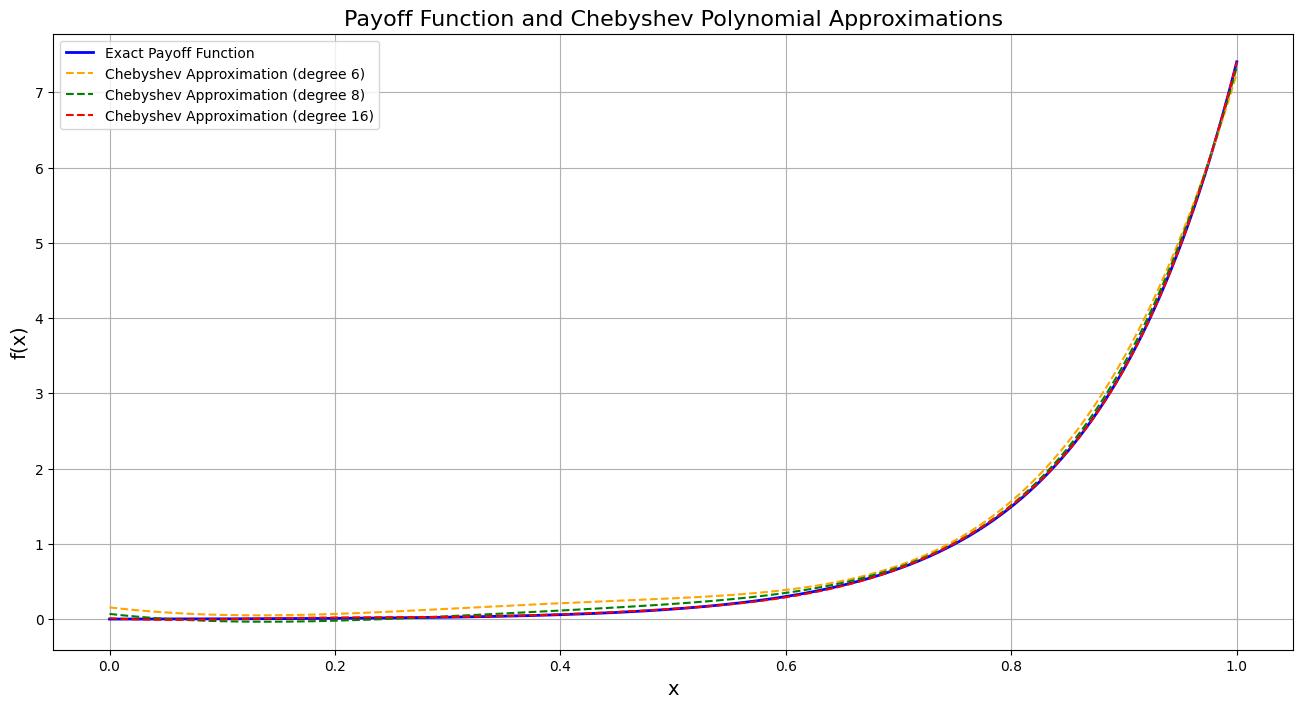

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the payoff function for a European call option (f(x) as in Eq. 35)
def payoff_function(x, S0, K, p):
    fmax = S0 * np.exp(2 * p) - K
    return np.maximum(0, S0 * np.exp(x * 2**p) - K) / fmax

# Define the objective function to minimize (difference between f(x) and Chebyshev polynomial)
def chebyshev_objective(c, x, f_x):
    chebyshev_poly = np.polynomial.chebyshev.Chebyshev(c)
    return np.max(np.abs(f_x - chebyshev_poly(x)))

# Generate Chebyshev polynomial approximation using scipy.optimize
def generate_chebyshev_approximation(degree, x, f_x):
    # Initial guess for the coefficients (zero)
    c0 = np.zeros(degree + 1)
    
    # Minimize the objective function to find the best coefficients
    result = minimize(chebyshev_objective, c0, args=(x, f_x), method="Powell")
    
    # Return the optimized Chebyshev polynomial
    return np.polynomial.chebyshev.Chebyshev(result.x)

# Parameters
S0 = 100  # Initial asset price
K = 100   # Strike price
p = 3     # Scaling factor

# Define x in the range [0, 1] for the payoff function with finer steps
x = np.linspace(0, 1,20000)

# Compute the exact payoff function values
f_x = payoff_function(x, S0, K, p)

# Compute Chebyshev polynomial approximations for degrees 6, 8, 16
P6 = generate_chebyshev_approximation(6, x, f_x)
P8 = generate_chebyshev_approximation(8, x, f_x)
P16 = generate_chebyshev_approximation(16, x, f_x)

# Plot the function and its polynomial approximations
plt.figure(figsize=(16, 8))
plt.plot(x, f_x, label='Exact Payoff Function', color='blue', lw=2)
plt.plot(x, P6(x), label='Chebyshev Approximation (degree 6)', linestyle='--', color='orange')
plt.plot(x, P8(x), label='Chebyshev Approximation (degree 8)', linestyle='--', color='green')
plt.plot(x, P16(x), label='Chebyshev Approximation (degree 16)', linestyle='--', color='red')

# Add labels and legend
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.title('Payoff Function and Chebyshev Polynomial Approximations', fontsize=16)
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()


In [133]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from scipy.special import chebyt

# Function to count non-Clifford gates in the circuit
def count_non_clifford_gates(qc):
    optimized_qc = transpile(qc, basis_gates=['u3', 'cx', 't'])
    # Counting gates that are not in the set of Clifford gates
    non_clifford_count = sum(1 for op in optimized_qc.data if op[0].name not in ['u1', 'u2', 'u3', 'cx', 'id', 'reset'])
    return optimized_qc.depth(), non_clifford_count

# Standard Reparameterization Method Implementation
def standard_reparameterization(num_assets, timesteps, num_qubits, S0, barrier):
    qc = QuantumCircuit(num_qubits)
    
    # Step 1: Initialize superposition of log-returns |r⟩ (H-gates to create superposition)
    for t in range(timesteps):
        for asset in range(num_assets):
            qc.h(asset + t*num_assets)  # Initialize each qubit for each timestep and asset
    
    # Step 2: Calculate asset prices S_t = S0 * exp(r_t)
    for t in range(timesteps):
        for asset in range(num_assets):
            qubit_index = asset + t * num_assets
            qc.ry(0.1 * np.log(S0), qubit_index)  # Simulate exp(log-return)
    
    # Step 3: Evaluate the payoff max(0, ST - K) using controlled NOT gates
    for asset in range(num_assets):
        expiration_qubit = asset + (timesteps - 1) * num_assets
        qc.cx(expiration_qubit, num_qubits - 1)  # Compare final price with barrier using control
    
    qc.measure_all()  # Measurement (for demonstration)
    return qc

# QSP Method Implementation
def qsp_method(num_assets, timesteps, num_qubits, S0, barrier, degree=8):
    qc = QuantumCircuit(num_qubits)
    
    # Step 1: Initialize superposition of log-returns |r⟩ (H-gates to create superposition)
    for t in range(timesteps):
        for asset in range(num_assets):
            qc.h(asset + t*num_assets)  # Initialize each qubit for each timestep and asset
    
    # Step 2: Apply QSP using Chebyshev polynomial approximation of degree `d`
    chebyshev_coeffs = chebyt(degree).coef
    
    # Apply QSP using controlled rotations based on Chebyshev approximation
    for i, coeff in enumerate(chebyshev_coeffs):
        if coeff != 0:
            for t in range(timesteps):
                for asset in range(num_assets):
                    qubit_index = asset + t * num_assets
                    qc.ry(coeff, qubit_index)  # Apply controlled rotation based on the coefficient
    
    # Step 3: Evaluate the payoff max(0, ST - K) using the QSP approximation
    for asset in range(num_assets):
        expiration_qubit = asset + (timesteps - 1) * num_assets
        qc.cx(expiration_qubit, num_qubits - 1)  # Compare final price with barrier using control
    
    qc.measure_all()  # Measurement (for demonstration)
    return qc

# Example usage
num_assets = 3
timesteps = 20
num_qubits = num_assets * timesteps + 5  # +5 for ancilla and measurement qubits
S0 = 100
barrier = 110

# Standard Reparameterization Method
qc_standard = standard_reparameterization(num_assets, timesteps, num_qubits, S0, barrier)
t_depth_standard, non_clifford_count_standard = count_non_clifford_gates(qc_standard)

# QSP Method with degree 8 polynomial
qc_qsp = qsp_method(num_assets, timesteps, num_qubits, S0, barrier, degree=8)
t_depth_qsp, non_clifford_count_qsp = count_non_clifford_gates(qc_qsp)

# Output the results
print(f"Standard Reparameterization Method:")
print(f"T-depth: {t_depth_standard}")
print(f"Non-Clifford Count: {non_clifford_count_standard}")
print(f"Qubit Count: {qc_standard.num_qubits}")

print(f"\nQSP Method:")
print(f"T-depth: {t_depth_qsp}")
print(f"Non-Clifford Count: {non_clifford_count_qsp}")
print(f"Qubit Count: {qc_qsp.num_qubits}")

# Calculate the improvement ratios
t_depth_improvement = t_depth_standard / t_depth_qsp if t_depth_qsp != 0 else float('inf')
non_clifford_improvement = non_clifford_count_standard / non_clifford_count_qsp if non_clifford_count_qsp != 0 else float('inf')

# Print the improvements
print(f"\nImprovements (Standard -> QSP):")
print(f"T-depth improvement: {t_depth_improvement:.2f}x")
print(f"Non-Clifford count improvement: {non_clifford_improvement:.2f}x")


Standard Reparameterization Method:
T-depth: 5
Non-Clifford Count: 66
Qubit Count: 65

QSP Method:
T-depth: 5
Non-Clifford Count: 66
Qubit Count: 65

Improvements (Standard -> QSP):
T-depth improvement: 1.00x
Non-Clifford count improvement: 1.00x


C:\Users\Rajat\AppData\Local\Temp\ipykernel_17912\396342754.py:10: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  non_clifford_count = sum(1 for op in optimized_qc.data if op[0].name not in ['u1', 'u2', 'u3', 'cx', 'id', 'reset'])


In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator
import numpy as np

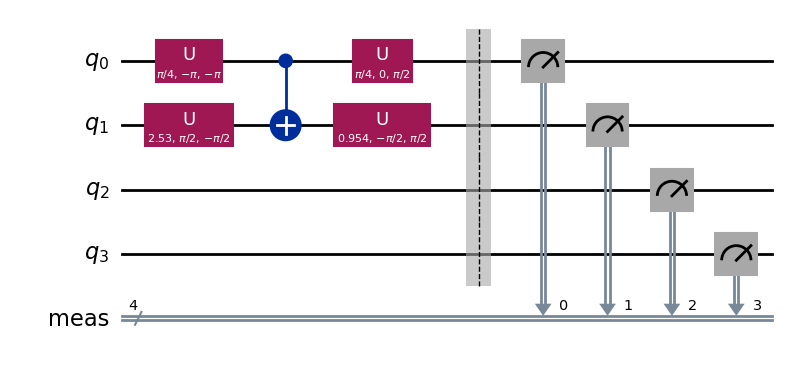

In [4]:
num_qubits = 4  # For example, 3 qubits for the main system and 1 ancilla
qc = QuantumCircuit(num_qubits)

# Example unitary matrix for A (can be replaced with any other Hermitian matrix)
A = np.array([[0.5, 0.5], [0.5, -0.5]])
identity = np.eye(2)
U = np.block([[A, 1j*np.sqrt(identity - A @ A)], [1j*np.sqrt(identity - A @ A), A]])

# Apply the oracle using the Operator
U_operator = Operator(U)
qc.unitary(U_operator, range(2), label="Block Encoding")

# Measure the ancilla qubit
qc.measure_all()

qc.decompose().draw(output="mpl")

In [7]:
from qiskit import QuantumCircuit,transpile

from qiskit.circuit.library import RZGate, RXGate
import numpy as np

# Define the number of qubits
n = 2  # Number of qubits for the system
anc = 1  # Additional ancilla qubit
qc = QuantumCircuit(n + anc)

# Define the angles (ϕ) for the QSP phases (these can be tuned)
phi = [np.pi / 4, np.pi / 2]  # Example phases for QSP

# Define the unitary U_phi, which is controlled by the phases phi and implements the Chebyshev polynomial
def U_phi(qc, n, phi):
    # Apply controlled RZ and RX gates based on the phases
    for i in range(len(phi)):
        qc.append(RZGate(phi[i]), [n])  # Apply RZ(phi) gate
        qc.append(RXGate(phi[i]), [n])  # Apply RX(phi) gate

# Apply the QSP sequence
def QSP_circuit(qc, n, anc, phi):
    # Initial state preparation (you can adjust this to your needs)
    qc.h(range(n))  # Apply Hadamard gates to all qubits (example)

    # Apply U_phi with controlled projectors
    U_phi(qc, n, phi)
    
    # Reflecting the signal by applying U† (conjugate transpose of U)
    qc.append(RXGate(-phi[0]), [n])  # Inverse of the previous RX
    qc.append(RZGate(-phi[1]), [n])  # Inverse of the previous RZ

    # Measure the ancilla qubit
    qc.measure_all()

# Build and run the circuit
QSP_circuit(qc, n, anc, phi)

# Simulate the circuit
backend = AerSimulator()
compiled=transpile(qc,backend=backend)
job = backend.run(compiled,shots=1024)
result = job.result()

# Get counts (measurement results)
counts = result.get_counts(qc)
print(counts)


{'010': 214, '111': 59, '001': 192, '011': 181, '000': 167, '100': 71, '101': 67, '110': 73}


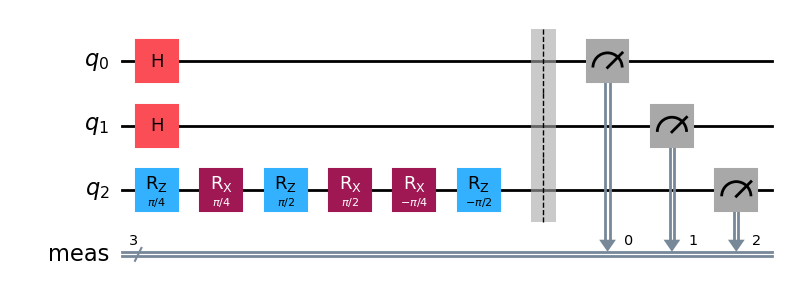

In [8]:
qc.draw(output="mpl")

In [7]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial import Chebyshev
import paddle

# PaddleQuantum related packages
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.qinfo import dagger
from paddle_quantum.linalg import unitary_random_with_hermitian_block
from paddle_quantum.state import random_state,completely_mixed_computational


In [14]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector, DensityMatrix
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from scipy.linalg import expm

In [12]:
# Helper function to create a random Hermitian matrix
def random_hermitian_matrix(dimension):
    A = np.random.rand(dimension, dimension) + 1j * np.random.rand(dimension, dimension)
    A = A + A.conj().T  # Make the matrix Hermitian
    return A

# 1. Define number of qubits and the block Hermitian matrix
num_qubits = 3
num_block_qubits = 2
dim_block = 2 ** num_block_qubits

# Generate a random Hermitian matrix A (2-qubit block matrix)
A = random_hermitian_matrix(dim_block)

print(A)

[[0.76957241+0.j         1.35212851-0.66695185j 1.39171137+0.56674074j
  0.79415039-0.61550049j]
 [1.35212851+0.66695185j 1.32118122+0.j         1.02962119+0.45879628j
  1.5506101 -0.72491498j]
 [1.39171137-0.56674074j 1.02962119-0.45879628j 0.46579193+0.j
  1.27134572-0.13772404j]
 [0.79415039+0.61550049j 1.5506101 +0.72491498j 1.27134572+0.13772404j
  1.52928751+0.j        ]]


In [18]:
def random_statevector(dim):
    state = np.random.rand(dim) + 1j * np.random.rand(dim)
    state /= np.linalg.norm(state)  # Normalize the statevector
    return state

# Helper function to generate a random density matrix from a random statevector
def random_density_matrix(num_qubits):
    dim = 2 ** num_qubits
    random_state = random_statevector(dim)  # Generate random statevector
    state = Statevector(random_state)  # Convert to Qiskit Statevector
    rho = DensityMatrix(state)  # Convert statevector to density matrix
    return rho


In [20]:
def random_hermitian_matrix(dimension):
    A = np.random.rand(dimension, dimension) + 1j * np.random.rand(dimension, dimension)
    A = A + A.conj().T  # Make the matrix Hermitian
    return A

# Helper function to generate a random normalized statevector
def random_statevector(dim):
    state = np.random.rand(dim) + 1j * np.random.rand(dim)
    state /= np.linalg.norm(state)  # Normalize the statevector
    return state

# 1. Define number of qubits and the block Hermitian matrix
num_qubits = 3
num_block_qubits = 2
dim_block = 2 ** num_block_qubits

# Generate a random Hermitian matrix A (2-qubit block matrix)
A = random_hermitian_matrix(dim_block)

# 2. Construct a unitary matrix U using the matrix exponential of A
U_block = expm(1j * A)  # Exponential map to make U unitary

# Embed U_block into a larger unitary matrix for 3 qubits
U = np.eye(2**num_qubits, dtype=complex)
U[:dim_block, :dim_block] = U_block

# Convert to a Qiskit UnitaryGate
U_gate = UnitaryGate(U)

# 3. Prepare input state
# Create a random statevector (rho) for the input state
input_state = random_statevector(2 ** num_qubits)  # Generate random statevector

# Prepare the zero state for the ancilla qubits (in state vector form)
zero_state = np.zeros(2 ** (num_qubits - num_block_qubits), dtype=complex)
zero_state[0] = 1  # Zero state corresponds to [1, 0, 0,...]

# Combine the zero state (ancilla) with the input statevector
initial_state = np.kron(zero_state, input_state)  # Combine zero_state and input_state

# Convert the combined state to a Qiskit Statevector object
initial_state_qiskit = Statevector(initial_state)

# 4. Create the Qiskit quantum circuit
qc = QuantumCircuit(num_qubits)

# Apply the unitary U
qc.append(U_gate, range(num_qubits))

# 5. Perform measurement on auxiliary register (collapse operation equivalent)
# Measure the auxiliary qubits and reset their states to zero
aux_register = list(range(num_qubits - num_block_qubits))

# Add measurements on auxiliary qubits
qc.measure_all()

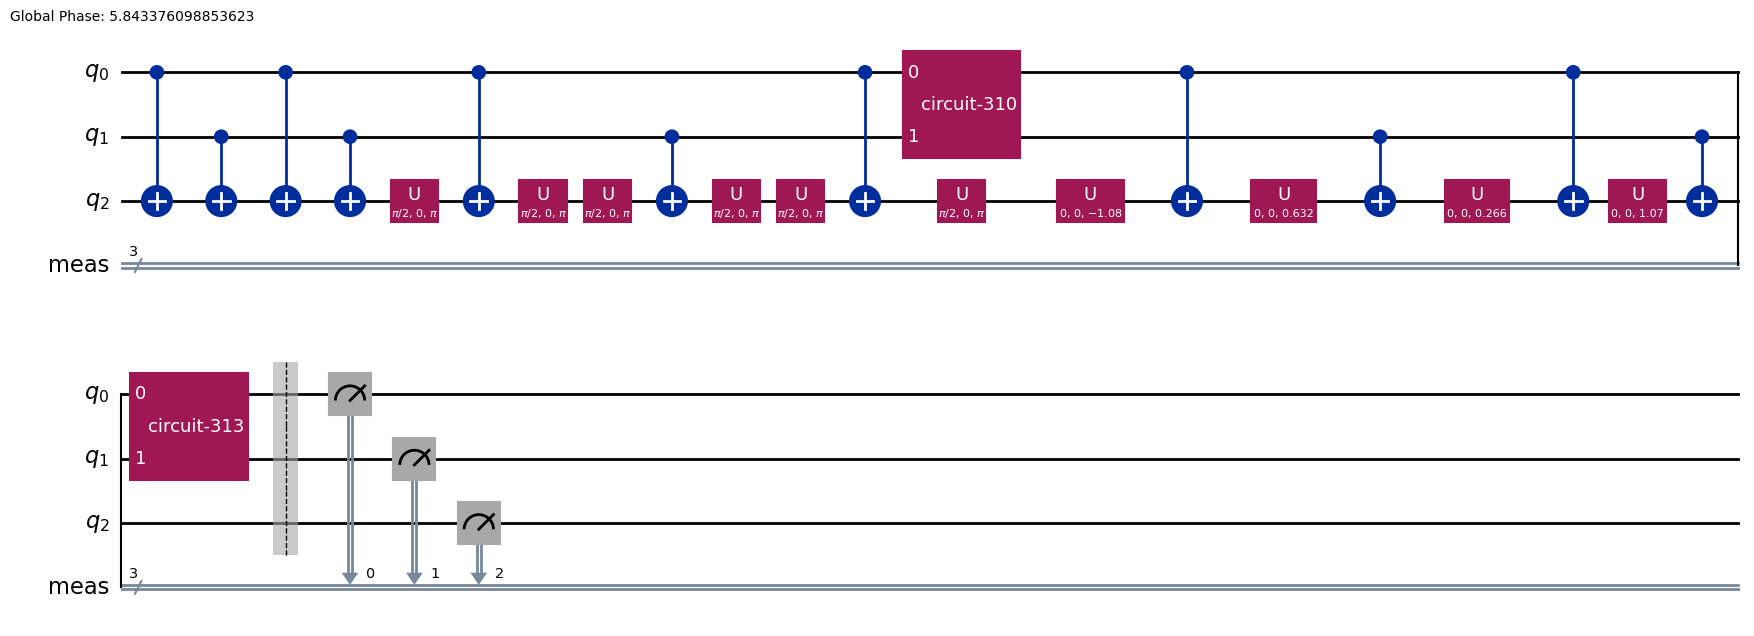

In [22]:
qc.decompose().draw(output="mpl")

In [23]:
P = Chebyshev([0 for _ in range(10)] + [1]).convert(kind=Polynomial)

In [24]:
print(P)

-1.0 + 0.0 x + 50.0 x**2 + 0.0 x**3 - 400.0 x**4 + 0.0 x**5 +
1120.0 x**6 + 0.0 x**7 - 1280.0 x**8 + 0.0 x**9 + 512.0 x**10


In [ ]:
from paddle_quantum.